In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
import torch
from torch import nn

df = pd.read_csv("data/synthetic_em_data.csv")
X = df[["Time", "dBdt"]].values
y = df[["Depth","Resistivity"]].values
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
class EMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

model = EMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [25]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

EPOCHS = 10000
for epoch in range(EPOCHS):
    model.train()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == 9999:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 1.031776
Epoch 100: Loss = 1.001517
Epoch 200: Loss = 1.000582
Epoch 300: Loss = 0.999698
Epoch 400: Loss = 0.998958
Epoch 500: Loss = 0.998225
Epoch 600: Loss = 0.997430
Epoch 700: Loss = 0.996786
Epoch 800: Loss = 0.996324
Epoch 900: Loss = 0.995831
Epoch 1000: Loss = 0.995434
Epoch 1100: Loss = 0.995097
Epoch 1200: Loss = 0.994804
Epoch 1300: Loss = 0.994582
Epoch 1400: Loss = 0.994359
Epoch 1500: Loss = 0.994193
Epoch 1600: Loss = 0.994074
Epoch 1700: Loss = 0.993964
Epoch 1800: Loss = 0.993898
Epoch 1900: Loss = 0.993865
Epoch 2000: Loss = 0.993812
Epoch 2100: Loss = 0.993779
Epoch 2200: Loss = 0.993753
Epoch 2300: Loss = 0.993730
Epoch 2400: Loss = 0.993714
Epoch 2500: Loss = 0.993720
Epoch 2600: Loss = 0.993713
Epoch 2700: Loss = 0.993675
Epoch 2800: Loss = 0.993678
Epoch 2900: Loss = 0.993645
Epoch 3000: Loss = 0.993640
Epoch 3100: Loss = 0.993636
Epoch 3200: Loss = 0.993630
Epoch 3300: Loss = 0.993611
Epoch 3400: Loss = 0.993602
Epoch 3500: Loss = 0.993636
Epoc

In [26]:
def predict_dbdt(time, dBdt):
    inp = torch.tensor(scaler_X.transform([[time, dBdt]]), dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred = model(inp)
    return scaler_y.inverse_transform(pred.numpy())[0][:2]

print(predict_dbdt(1e-05, -5.60886297079976E-10))

[-194.07242  786.67914]


In [ ]:
# !mkdir models
# torch.save(model.state_dict(), "models/em_model.pth")
# print(f"Model Saved to models/em_model.pth")

Model Saved to models/em_model.pth


c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\simpeg\base\pde_simulation.py:490: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


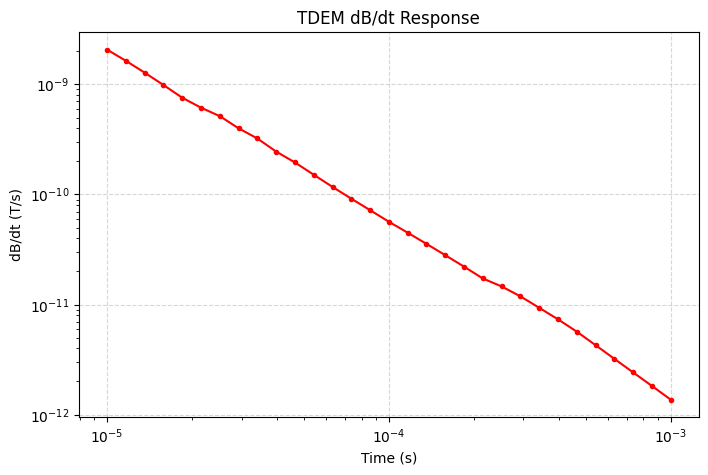

       Time  Resistivity_1  Resistivity_2  Resistivity_3  Thickness_1  \
0  0.000010            100             20              5           50   
1  0.000012            100             20              5           50   
2  0.000014            100             20              5           50   
3  0.000016            100             20              5           50   
4  0.000018            100             20              5           50   

   Thickness_2          dBdt  
0          100 -2.070896e-09  
1          100 -1.639606e-09  
2          100 -1.279740e-09  
3          100 -9.877367e-10  
4          100 -7.573322e-10  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from simpeg import (
    maps, optimization, data_misfit, regularization,
    inverse_problem, inversion, directives, utils, discretize
)
from simpeg.electromagnetics import time_domain

def generate_tdem_data(resistivities, thicknesses, plotIt=True):
    # Validate input
    n_layers = len(resistivities)
    assert len(thicknesses) == n_layers - 1, "Thickness list must be one less than resistivity list"

    cs, ncx, ncz, npad = 5.0, 25, 15, 15
    hx = [(cs, ncx), (cs, npad, 1.3)]
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = discretize.CylindricalMesh([hx, 1, hz], "00C")
    z = mesh.cell_centers_z

    active = z < 0.0
    actMap = maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.shape_cells[2])
    mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap

    # Build layer-based conductivity model
    sigma = np.ones(mesh.shape_cells[2]) * 1e-8
    depth_top = 0
    z_layers = -np.cumsum(thicknesses)

    for i, z_bot in enumerate(np.append(z_layers, -1e6)):
        sigma_layer = 1 / resistivities[i]
        layer = (z < depth_top) & (z >= z_bot)
        sigma[layer] = sigma_layer
        depth_top = z_bot

    mtrue = np.log(sigma[active])

    # Set up survey
    rxOffset = 1e-3
    rx = time_domain.Rx.PointMagneticFluxTimeDerivative(
        np.array([[rxOffset, 0.0, 30]]), np.logspace(-5, -3, 31), "z"
    )
    src = time_domain.Src.MagDipole([rx], location=np.array([0.0, 0.0, 80]))
    survey = time_domain.Survey([src])
    time_steps = [(1e-06, 20), (1e-05, 20), (0.0001, 20)]

    simulation = time_domain.Simulation3DElectricField(
        mesh, sigmaMap=mapping, survey=survey, time_steps=time_steps
    )

    data = simulation.make_synthetic_data(mtrue, relative_error=0.05)
    times = rx.times
    dBdt = data.dobs.flatten()

    # Create DataFrame
    data_rows = []
    for i, t in enumerate(times):
        row = [t] + resistivities + thicknesses + [dBdt[i]]
        data_rows.append(row)

    cols = ["Time"]
    cols += [f"Resistivity_{i+1}" for i in range(n_layers)]
    cols += [f"Thickness_{i+1}" for i in range(n_layers - 1)]
    cols += ["dBdt"]

    df = pd.DataFrame(data_rows, columns=cols)
    df.to_csv("layered_synthetic_tdem.csv", index=False)

    if plotIt:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.loglog(times, -dBdt, "r.-")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("dB/dt (T/s)")
        ax.grid(True, linestyle="--", alpha=0.5)
        plt.title("TDEM dB/dt Response")
        plt.show()

    return df

# Example usage
if __name__ == "__main__":
    # 3-layer model: resistivities in ohm-m, thicknesses in meters
    resistivities = [100, 20, 5]      # Resistivity_1, _2, _3
    thicknesses = [50, 100]           # Thickness_1, _2
    df = generate_tdem_data(resistivities, thicknesses)
    print(df.head())
